# STOCHASTIC GRADIENT DESCENT (SGD)

# $\theta ^{j+1} := \theta ^{j} - \eta(\epsilon _{j})x_{j}$

<b>$\theta ^{j+1}$ : Next location
<b>$\theta ^{j}$ : Current location
<b>$\eta$ : Learning coefficient
<b>$\epsilon_{j}$ : Error of J data point
<b>$x_{j}$ : The value of the J th feature

In [1]:
import warnings as wrn
wrn.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score,KFold
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import SGDRegressor,LinearRegression

from yellowbrick.model_selection import CVScores


In [2]:
df = pd.read_csv('real_estate.csv')
df.head()

,Unnamed: 0,price,rooms,m2,floor,age,price_pred
0,0,475,1,40,0,6,437.210859
1,1,475,1,55,0,5,462.589482
2,2,450,1,50,0,7,446.916549
3,3,450,1,55,1,6,465.388095
4,4,475,1,45,2,7,454.152981


In [3]:
X = df.drop(['Unnamed: 0','price'],axis=1)
y = df['price']

<b>SGD is sensitive to the scale of the properties and target variables, so we apply standard scaling to the values of all variables.

In [4]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X = X_scaler.fit_transform(X)

y = y_scaler.fit_transform(y.values.reshape(-1,1))

<b>HOLD-OUT

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=0.2)

In [6]:
sgd_reg = SGDRegressor(random_state=42,penalty='elasticnet')

<b>For the penalty rule in SGD optimization, we used the ElasticNet regression, which evaluates the L1 and L2 rules together. In this case, we need to determine how much weight we will make for L1 and L2.

<b>Hyperparameter Optimization

In [7]:
params = {'alpha' : [0.0001,0.001,0.01],
          'eta0' : [0.0001,0.001,0.01,0.1],
          'l1_ratio' : [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
          'learning_rate' : ['constant','optimal','inscaling','adaptive'],
          'max_iter' : [50,100,500,1000]}

sgd_Gs = GridSearchCV(sgd_reg,params,n_jobs=-1,scoring='r2',cv=5).fit(X_train,y_train)

In [8]:
sgd_Gs.best_params_

{'alpha': 0.01,
 'eta0': 0.1,
 'l1_ratio': 0,
 'learning_rate': 'adaptive',
 'max_iter': 50}

<b>If l1_ratio = 1, the SGD model would be built according to Lasso(L1), if l1_ratio = 0, it would be built according to Ridge(L2).
The l1_ratio being 0.7 means that the linear regression model will be evaluated according to the ElasticNet regression.

In [9]:
sgd_Gs.best_estimator_

SGDRegressor(alpha=0.01, eta0=0.1, l1_ratio=0, learning_rate='adaptive',
             max_iter=50, penalty='elasticnet', random_state=42)

<b>R2 of the optimum model

In [10]:
sgd_Gs.best_score_

0.7089778498327137

<b>Final Model

In [11]:
sgd_final = sgd_reg.set_params(**sgd_Gs.best_params_).fit(X_train,y_train)

<b>Cross-Validate

In [12]:
scores = cross_val_score(sgd_final,X_train,y_train,cv=5)

In [13]:
scores

array([0.61266736, 0.87214328, 0.75726853, 0.58050545, 0.72230462])

<b>visualization of cross-validation results

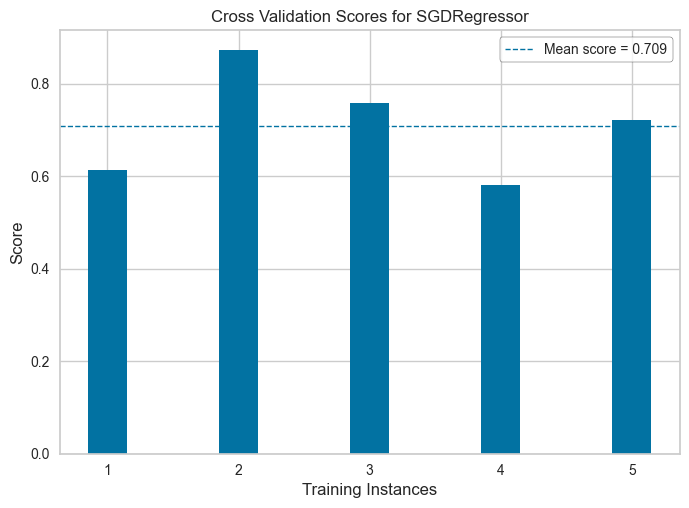

<Axes: title={'center': 'Cross Validation Scores for SGDRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [14]:
cv= KFold(n_splits=5)
model = sgd_final
visualizer = CVScores(model,cv=cv,scoring='r2').fit(X_train,y_train)
visualizer.show()

<b>Estimation parameters coefficients

In [15]:
sgd_final.intercept_

array([0.01093428])

In [16]:
sgd_final.coef_

array([ 0.19700304,  0.1153794 ,  0.08378144, -0.07969463,  0.16484998])

- $\hat{y} =0.016 + 0.293*rooms + 0.16*m_{2} + 0.111*floor - 0.128*age$

In [17]:
print(f'Train R2 :',{sgd_final.score(X_train,y_train)})
print(f'Test R2 :',{sgd_final.score(X_test,y_test)})

Train R2 : {0.7299853911877343}
Test R2 : {0.6874441493629173}


In [18]:
df['pred_price'] = sgd_final.predict(X)

df['pred_price'] = y_scaler.inverse_transform(df['pred_price'].values.reshape(-1,1))

df[['price','pred_price']].head()

,price,pred_price
0,475,443.482698
1,475,467.598248
2,450,453.572965
3,450,471.478766
4,475,461.676959


<b> Graph

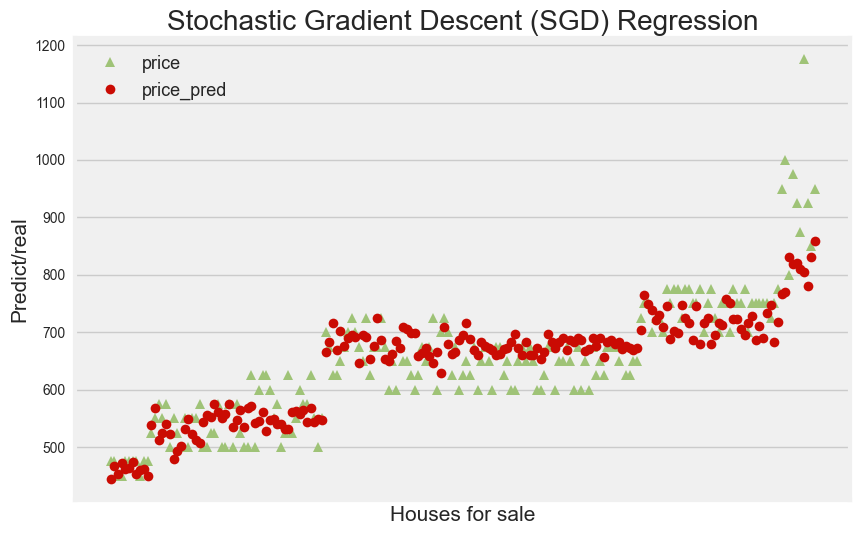

In [19]:
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
plt.title('Stochastic Gradient Descent (SGD) Regression')
plt.xticks(df['price'],df.index.values)
plt.plot(df['price'],'g^',label='price')
plt.xticks(df['pred_price'],df.index.values)
plt.plot(df['pred_price'],'ro',label='price_pred')
plt.xlabel('Houses for sale',fontsize=15)
plt.ylabel('Predict/real',fontsize=15)
plt.legend(fontsize=13,loc='upper left')
plt.show()

<b>SGD optimization and Linear Regression Performance Comparison

In [20]:
MSE_train = mean_squared_error(y_train,sgd_final.predict(X_train))
print('Train MSE:',y_scaler.inverse_transform(MSE_train.reshape(-1,1))[0,0])

MSE_test = mean_squared_error(y_test,sgd_final.predict(X_test))
print('Test MSE: ',y_scaler.inverse_transform(MSE_test.reshape(-1,1))[0,0])

Train MSE: 454.3991885602004
Test MSE:  455.8884561400035


<b>Linear Regression

In [21]:
X = df[['rooms','m2','floor','age']]
y = df['price']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [22]:
lr =LinearRegression().fit(X_train,y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [23]:
print('Linear Reg Train MSE :',mean_squared_error(y_train,y_train_pred))
print('Linear Reg Test MSE :',mean_squared_error(y_test,y_test_pred))

Linear Reg Train MSE : 3145.0627316271507
Linear Reg Test MSE : 4115.003886902744


In [24]:
print('Linear Reg Train R2 :',lr.score(X_train,y_train))
print('Linear Reg Test R2 :',lr.score(X_test,y_test))

Linear Reg Train R2 : 0.733739961656849
Linear Reg Test R2 : 0.6987282352837991


<b>The error of the optimum model determined as a result of SGD optimization (MSE was used as a criterion) was found to be 454 for the training data and 455 for the test set. The error values of the classical linear regression model were found to be approximately 3145 for the training data and 4115 for the test data. Thus, it was revealed that the classical multiple linear regression model was not the model with the lowest possible error.